# Sampling Over Waveform Uncertainty

In this tutorial, we demonstrate using this package to construct a prior of waveform uncertainty parameters and then using bilby to sample them. For more information, see [Equations and Notation](https://waveformuncertainty.readthedocs.io/en/latest/WFU_Equations.html) and [Likelihood Derivation](https://waveformuncertainty.readthedocs.io/en/latest/Likelihood_Equation.html). This notebook can be downloaded [here](https://github.com/RyanSR71/waveform_uncertainty/blob/main/docs/source/notebooks/WFU_Sampling_Tutorial.ipynb).

The following cell is everything we need to import to run this tutorial. We also import the `WaveformUncertainty` package, which will need to be installed first. See [Installation](https://waveformuncertainty.readthedocs.io/en/latest/installation.html#installation).

In [2]:
import os
import numpy as np
import bilby
import matplotlib.pyplot as plt
import lal
import pesummary
import scipy
from pesummary.gw.file.strain import StrainData
from pesummary.io import read
import requests
import WaveformUncertainty as wfu

## Setting Up the Prior

Here we set up a GW170817-like prior with bilby.

In [3]:
prior = bilby.core.prior.PriorDict()

prior['mass_1'] = bilby.core.prior.Uniform(name='mass_1',latex_label=r'$m_{1}$',minimum=1.37563293,maximum=1.80367393)
prior['mass_2'] = bilby.core.prior.Uniform(name='mass_2',latex_label=r'$m_{2}$',minimum=1.06371259,maximum=1.3758219)
prior['chi_1'] = bilby.core.prior.Uniform(name='chi_1',latex_label=r'$\chi_{1}$',minimum=-0.04999248, maximum=0.04999640)
prior['chi_2'] = bilby.core.prior.Uniform(name='chi_2',latex_label=r'$\chi_{2}$',minimum=-0.04998328, maximum=0.04997533)
prior['lambda_1'] = bilby.core.prior.Uniform(name="lambda_1",latex_label=r'$\Lambda_{1}$',minimum=0.00147326, maximum=3154.41685213)
prior['lambda_2'] = bilby.core.prior.Uniform(name="lambda_2",latex_label=r'$\Lambda_{2}$',minimum=0.02966776, maximum=4598.76616739)
prior['luminosity_distance'] = bilby.gw.prior.UniformSourceFrame(name='luminosity_distance',latex_label=r'$d_{L}$',minimum=12.27167145, maximum=52.94141976, unit='Mpc')
prior['phi_12'] = bilby.core.prior.Uniform(name='phi_12',latex_label=r'$\Phi_{12}$',minimum=0.00022415, maximum=6.28307139,boundary='periodic')
prior['phi_jl'] = bilby.core.prior.Uniform(name='phi_jl',latex_label=r'$\Phi_{JL}$',minimum=0.00038279, maximum=6.28301577,boundary='periodic')
prior['theta_jn'] = bilby.core.prior.Sine(name='theta_jn',latex_label=r'$\theta_{JN}$')
prior['phase'] = bilby.core.prior.Uniform(name='phase',latex_label=r'$\Phi$',minimum=0.000089295926, maximum=6.2830611, boundary='periodic')
prior['geocent_time'] = bilby.core.prior.Uniform(name="geocent_time",latex_label=r'$t_{c}$',minimum=1187008882.3, maximum=1187008882.5)
prior['dec'] = bilby.core.prior.DeltaFunction(name='dec',latex_label=r'$\delta$',peak=-0.408084)
prior['ra'] = bilby.core.prior.DeltaFunction(name='ra',latex_label=r'$\alpha_{r}$',peak=3.44616)
prior['psi'] = bilby.core.prior.DeltaFunction(name='psi',latex_label=r'$\Psi$',peak=1.56379256)

<br>

We then load in a set of parameterized waveform differences from which we will get our waveform uncertainties.

In [4]:
# downloading the file and saving to a folder
try:
    os.mkdir('tutorial_files')
except:
    pass
file = requests.get('https://github.com/RyanSR71/waveform_uncertainty/raw/main/files/parameterization_nsamples_1000.npy', allow_redirects=True)
open("tutorial_files/parameterization_nsamples_1000.npy", 'wb').write(file.content)

# loading the file
parameterization = np.load("tutorial_files/parameterization_nsamples_1000.npy",allow_pickle=True)

# calculating the means and standard deviations of the waveform differences
mean_amplitude_difference,amplitude_uncertainty,mean_phase_difference,phase_uncertainty,frequency_grid = wfu.uncertainties_from_parameterization(parameterization,linear=True,resolution=0.1)

<br>

Using the standard deviations of our waveform differences,  $\delta{A}$ and $\delta\Phi$, and the means of our waveform differences, $\overline{\Delta{A}}$ and $\overline{\Delta\Phi}$, we set up our prior distributions and add it to the previously defined prior.

In [5]:
# we also choose to use 6 geometrically spaced frequency nodes, as that configuration yields the best results
prior,frequency_nodes = wfu.WFU_prior(mean_amplitude_difference=mean_amplitude_difference,
                                     amplitude_uncertainty=amplitude_uncertainty,
                                     mean_phase_difference=mean_phase_difference,
                                     phase_uncertainty=phase_uncertainty,spacing='geometric',
                                     frequency_grid=frequency_grid,nnodes=6,prior=prior)

<br>

If we look at the prior, we confirm that the new parameters have been added properly:

In [6]:
prior

{'mass_1': Uniform(minimum=1.37563293, maximum=1.80367393, name='mass_1', latex_label='$m_{1}$', unit=None, boundary=None),
 'mass_2': Uniform(minimum=1.06371259, maximum=1.3758219, name='mass_2', latex_label='$m_{2}$', unit=None, boundary=None),
 'chi_1': Uniform(minimum=-0.04999248, maximum=0.0499964, name='chi_1', latex_label='$\\chi_{1}$', unit=None, boundary=None),
 'chi_2': Uniform(minimum=-0.04998328, maximum=0.04997533, name='chi_2', latex_label='$\\chi_{2}$', unit=None, boundary=None),
 'lambda_1': Uniform(minimum=0.00147326, maximum=3154.41685213, name='lambda_1', latex_label='$\\Lambda_{1}$', unit=None, boundary=None),
 'lambda_2': Uniform(minimum=0.02966776, maximum=4598.76616739, name='lambda_2', latex_label='$\\Lambda_{2}$', unit=None, boundary=None),
 'luminosity_distance': bilby.gw.prior.UniformSourceFrame(minimum=12.27167145, maximum=52.94141976, cosmology='Planck15', name='luminosity_distance', latex_label='$d_{L}$', unit='Mpc', boundary=None),
 'phi_12': Uniform(mini

<br>

## Visualizing the Prior

Our model waveform uncertainty priors are defined as a normal distributions in amplitude and phase around $\overline{\Delta{A}}$ and $\overline{\Delta\Phi}$ with standard deviations being our waveform uncertainties, $\delta{A}$ and $\delta\Phi$. Each $\alpha$ and $\beta$ parameter is a piece of the total distribution along its corresponding frequency node $f_{n}$. Here, we have 6 frequency nodes spaced geometrically, so we have 6 $\alpha$ parameters and 6 $\beta$ parameters.

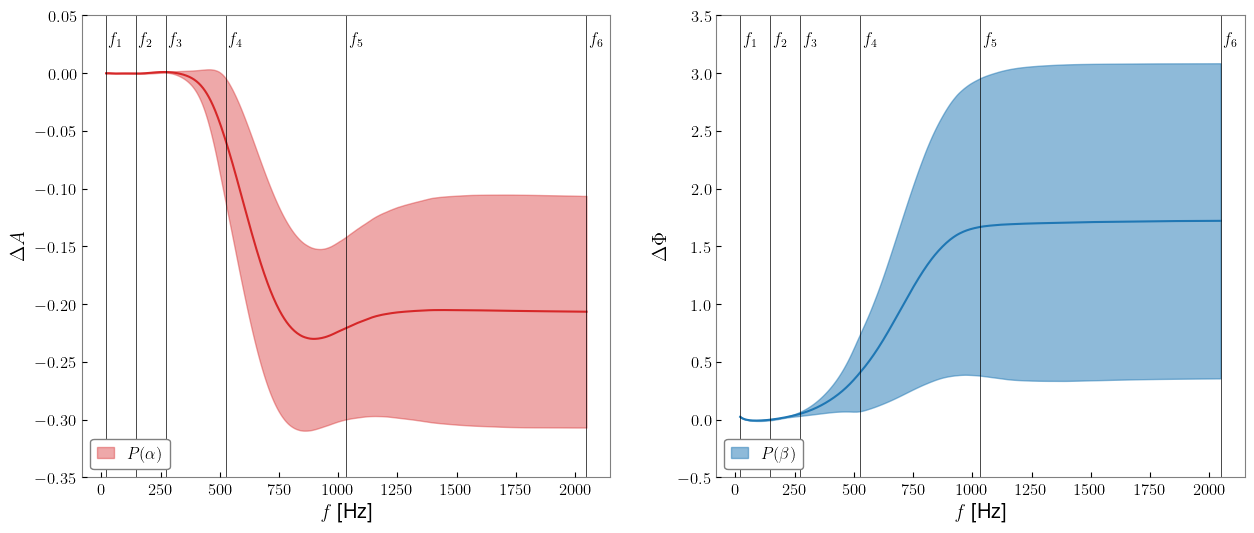

In [7]:
fig,ax = plt.subplots(1,2,figsize=(15,6))

# plotting the prior
ax[0].fill_between(frequency_grid,mean_amplitude_difference-amplitude_uncertainty,mean_amplitude_difference+amplitude_uncertainty,color='tab:red',alpha=0.4,label=r'$P(\alpha)$',zorder=1)
ax[0].plot(frequency_grid,mean_amplitude_difference,color='tab:red')
# plotting the frequency nodes
for i in range(len(frequency_nodes)):
    ax[0].axvline(frequency_nodes[i],color='k',linewidth=0.5)
    ax[0].annotate(r'$f_{val}$'.replace('val',str(i+1)),(frequency_nodes[i]+10,0.025))

ax[0].legend(fancybox=True,loc='lower left',framealpha=1)
ax[0].set_ylim(-0.35,0.05)
ax[0].grid(False)
ax[0].set_xlabel(r"$\mathit{f}$ [Hz]")
ax[0].set_ylabel(r"$\Delta{A}$")
ax[0].tick_params(direction='in')

# plotting the prior
ax[1].fill_between(frequency_grid,mean_phase_difference-phase_uncertainty,mean_phase_difference+phase_uncertainty,color='tab:blue',alpha=0.5,label=r'$P(\beta)$',zorder=1)
ax[1].plot(frequency_grid,mean_phase_difference,color='tab:blue')
# plotting the frequency nodes
for i in range(len(frequency_nodes)):
    ax[1].axvline(frequency_nodes[i],color='k',linewidth=0.5)
    ax[1].annotate(r'$f_{val}$'.replace('val',str(i+1)),(frequency_nodes[i]+10,3.25))

ax[1].legend(fancybox=True,loc='lower left',framealpha=1)
ax[1].set_ylim(-0.5,3.5)
ax[1].grid(False)
ax[1].set_xlabel(r"$\mathit{f}$ [Hz]")
ax[1].set_ylabel(r"$\Delta\Phi$")
ax[1].tick_params(direction='in')

plt.show()

<br>

## Parameter Estimation Example

In this section, we will show how to use `WaveformUncertainty.WaveformGeneratorWFU` to perfom parameter estimation with the waveform uncertainty parameters.

We start by setting up our waveform generator. We pass in the frequency nodes $f_{n}$ and specify that we want the each waveform uncertainty to be sampled. This will only work if the necessary number of $\alpha$ and $\beta$ parameters are in the prior.

In [8]:
hf = wfu.WaveformGeneratorWFU(
                parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                waveform_arguments=dict(waveform_approximant='IMRPhenomPv2_NRTidalv2', reference_frequency=50, catch_waveform_errors=True, 
                                        f_low = 20.0, f_high=2048.0),
                frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star, 
                sampling_frequency=4096, 
                duration=256,
                # waveform uncertainty arguments
                waveform_uncertainty_nodes=frequency_nodes,
                dA_sampling=True,
                dphi_sampling=True,
            )

16:05 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


<br>

With the waveform generator set up, we can perform a [standard parameter estimation](https://lscsoft.docs.ligo.org/bilby/visualising_the_results.html) run like with [bilby's waveform generator](https://lscsoft.docs.ligo.org/bilby/api/bilby.gw.waveform_generator.WaveformGenerator.html#bilby.gw.waveform_generator.WaveformGenerator). Here, we will show an example of a parameter estimation run with an injection.

In [9]:
# drawing a random sample from the prior for our injection
injection_parameters = prior.sample()

# setting up interferometers
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=4096, duration=256,
    start_time=injection_parameters['geocent_time'] - 3)
ifo_injection = ifos.inject_signal(
    waveform_generator=hf,
    parameters=injection_parameters)

# setting up likelihood
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    ifos,
    hf,
    priors=prior,
    time_marginalization=False, 
    phase_marginalization=False, 
    distance_marginalization=False,
)

16:05 bilby INFO    : Injected signal in H1:
16:05 bilby INFO    :   optimal SNR = 63.81
16:05 bilby INFO    :   matched filter SNR = 63.47+0.39j
16:05 bilby INFO    :   mass_1 = 1.7770748756999222
16:05 bilby INFO    :   mass_2 = 1.2932717464347407
16:05 bilby INFO    :   chi_1 = 0.02354988004379297
16:05 bilby INFO    :   chi_2 = -0.004573171109187833
16:05 bilby INFO    :   lambda_1 = 2553.6677564608103
16:05 bilby INFO    :   lambda_2 = 1811.1059907687923
16:05 bilby INFO    :   luminosity_distance = 40.153795420220625
16:05 bilby INFO    :   phi_12 = 2.885510142701156
16:05 bilby INFO    :   phi_jl = 6.170102720374984
16:05 bilby INFO    :   theta_jn = 2.5346780452296405
16:05 bilby INFO    :   phase = 2.8542253155195225
16:05 bilby INFO    :   geocent_time = 1187008882.4722216
16:05 bilby INFO    :   dec = -0.408084
16:05 bilby INFO    :   ra = 3.44616
16:05 bilby INFO    :   psi = 1.56379256
16:05 bilby INFO    :   alpha_1 = 5.826494092886299e-05
16:05 bilby INFO    :   alpha_2 

<br>

The following cell will run the parameter estimation, which will take days to complete, so it will not be run here.

In [ ]:
result = bilby.run_sampler(
    likelihood, prior, sampler='nestle', 
    label="example",
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
    nlive=1000, 
    dlogz=1.,
    clean=True,
    maxiter=None,
)

<br>

## Examining the Results

We will look at a premade result file from a parameter estimation run that includes the waveform uncertainty parameters.

In [10]:
# downloading the file and saving to a folder
try:
    os.mkdir('tutorial_files')
except:
    pass
file = requests.get('https://github.com/RyanSR71/waveform_uncertainty/raw/main/files/NS1_wfu_nlive_100_result.json', allow_redirects=True)
open("tutorial_files/result.json", 'wb').write(file.content)

# loading in the file
result = bilby.read_in_result('tutorial_files/result.json')

<br>

We can look at a corner plot of a few dimensions to show that the waveform uncertainty parameters were sampled correctly.

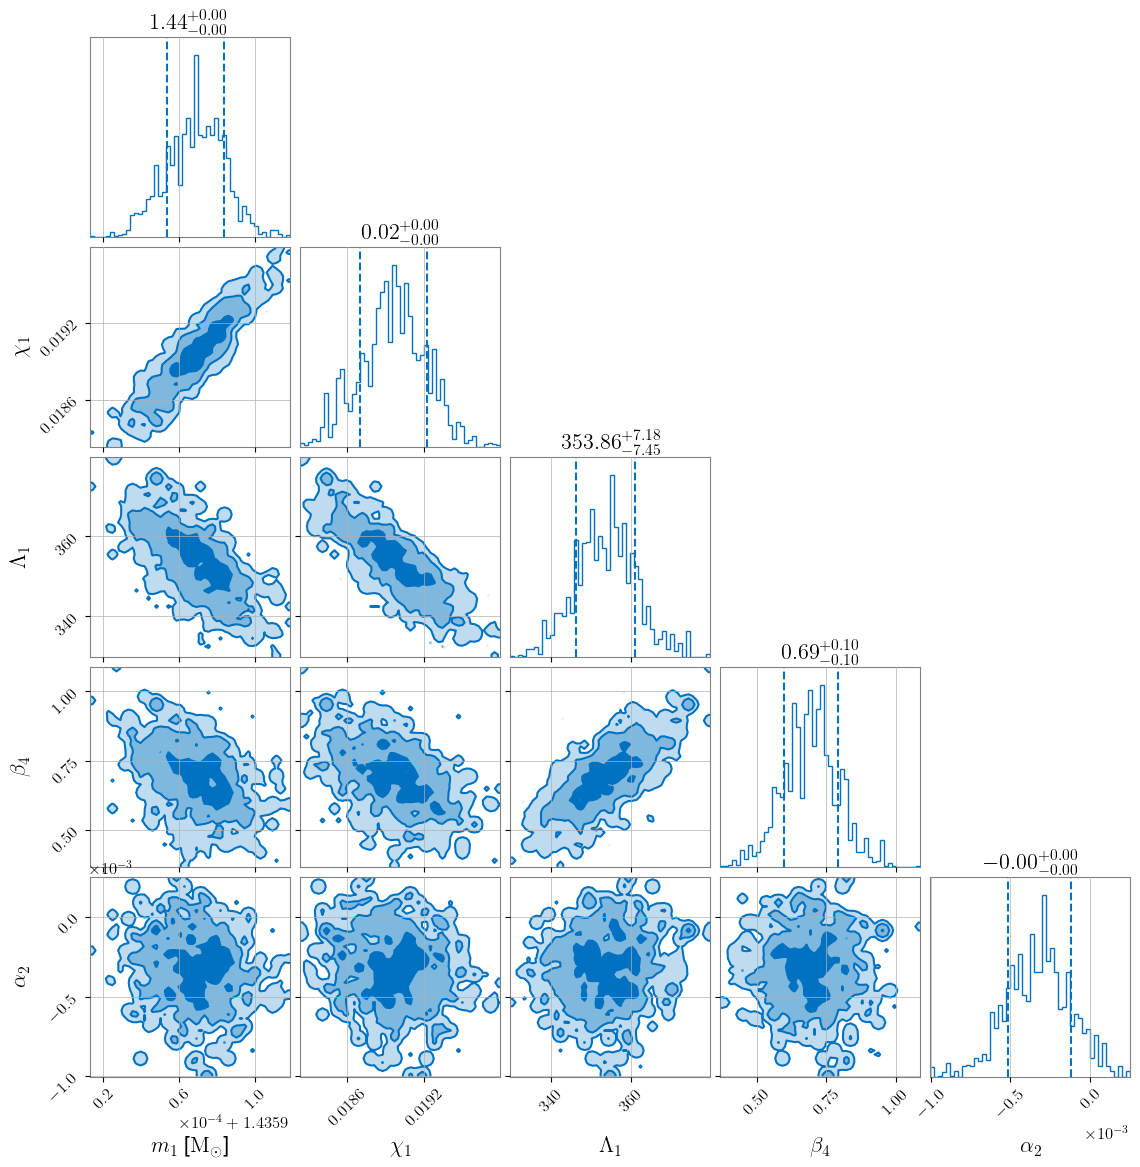

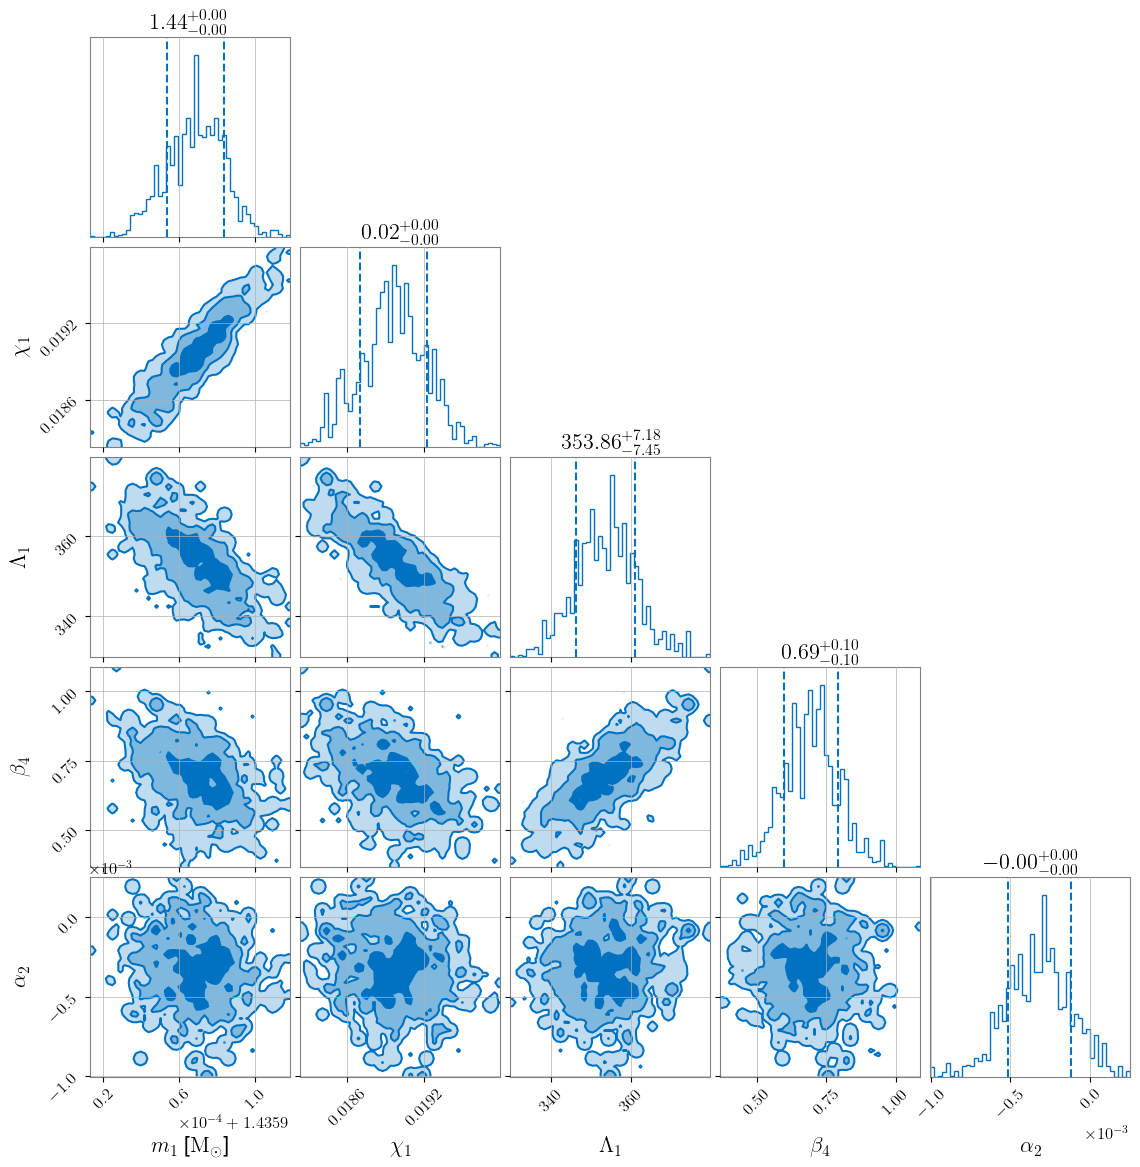

In [11]:
result.plot_corner(['mass_1','chi_1','lambda_1','beta_4','alpha_2'],save=False)

<br>

If we load in the result file as a [PESummary](https://docs.ligo.org/lscsoft/pesummary/latest/) `samples_dict` object, we can find the maximum likelihood values for the waveform uncertainty parameters.

lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


2024-08-03  16:06:07 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2024-08-03  16:06:07 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2024-08-03  16:06:07 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default
2024-08-03  16:06:07 PESummary WARNING : Could not find f_low in input file and one was not passed from the command line. Using 20.0Hz as default
2024-08-03  16:06:07 PESummary INFO    : Skipping remnant calculations as tidal deformability parameters found in the posterior table.
2024-08-03  16:06:07 PESummary WARNING : The redshift is being approximated using interpolation. Bear in mind that this does introduce a small error.


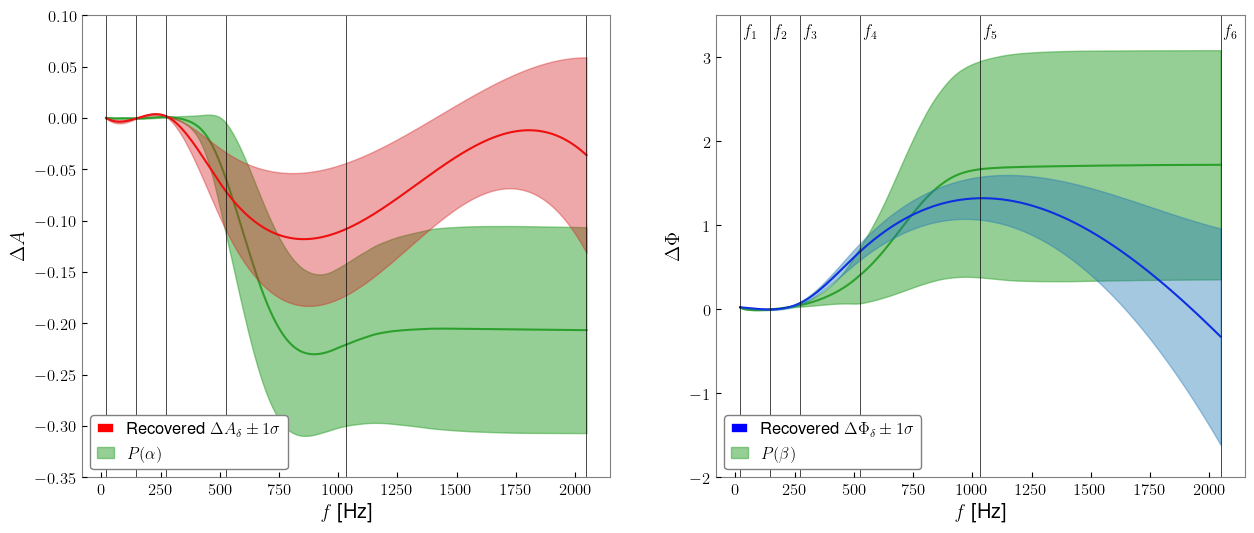

In [12]:
posterior = read('tutorial_files/result.json',allow_pickle=True).samples_dict

# collecting maximum likelihood values and their standard deviations
alphas = [float(posterior.maxL[f'alpha_{i+1}']) for i in range(len(frequency_nodes))]
betas = [float(posterior.maxL[f'beta_{i+1}']) for i in range(len(frequency_nodes))]
dA = [float(np.std(posterior[f'alpha_{i+1}'])) for i in range(len(frequency_nodes))]
dphi = [float(np.std(posterior[f'beta_{i+1}'])) for i in range(len(frequency_nodes))]

# setting up boundaries for the 68% confidence interval around the maximum likelihood values
dA_upper_bound = np.array(alphas)+np.array(dA)
dA_lower_bound = np.array(alphas)-np.array(dA)
dphi_upper_bound = np.array(betas)+np.array(dphi)
dphi_lower_bound = np.array(betas)-np.array(dphi)
    
# plotting
fig,ax = plt.subplots(1,2,figsize=(15,6))

# using the waveform uncertainty parameters and the frequency nodes to construct a spline curve
ax[0].plot(frequency_grid,scipy.interpolate.CubicSpline(frequency_nodes,alphas)(frequency_grid),color='red',label=r'Recovered $\Delta{A}_{\delta}\pm 1\sigma$')
# plotting the 68% confidence interval
ax[0].fill_between(frequency_grid,scipy.interpolate.CubicSpline(frequency_nodes,dA_upper_bound)(frequency_grid),
                   scipy.interpolate.CubicSpline(frequency_nodes,dA_lower_bound)(frequency_grid),
                   color='tab:red',alpha=0.4,zorder=2)

# plotting the prior for comparison
ax[0].fill_between(frequency_grid,mean_amplitude_difference-amplitude_uncertainty,mean_amplitude_difference+amplitude_uncertainty,color='tab:green',alpha=0.5,label=r'$P(\alpha)$',zorder=1)
ax[0].plot(frequency_grid,mean_amplitude_difference,color='tab:green',zorder=1)
# plotting the frequency nodes
for i in range(len(frequency_nodes)):
    ax[0].axvline(frequency_nodes[i],color='k',linewidth=0.5)
    ax[0].annotate(r'$f_{val}$'.replace('val',str(i+1)),(frequency_nodes[i]+10,0.75))
    
ax[0].legend(fancybox=True,loc='lower left',framealpha=1)
ax[0].set_ylim(-0.35,0.1)
ax[0].grid(False)
ax[0].set_xlabel(r"$\mathit{f}$ [Hz]")
ax[0].set_ylabel(r"$\Delta{A}$")
ax[0].tick_params(direction='in')

# using the waveform uncertainty parameters and the frequency nodes to construct a spline curve
ax[1].plot(frequency_grid,scipy.interpolate.CubicSpline(frequency_nodes,betas)(frequency_grid),color='blue',label=r'Recovered $\Delta\Phi_{\delta}\pm 1\sigma$')
# plotting the 68% confidence interval
ax[1].fill_between(frequency_grid,scipy.interpolate.CubicSpline(frequency_nodes,dphi_upper_bound)(frequency_grid),
                   scipy.interpolate.CubicSpline(frequency_nodes,dphi_lower_bound)(frequency_grid),
                   color='tab:blue',alpha=0.4,zorder=2)

# plotting the prior for comparison
ax[1].fill_between(frequency_grid,mean_phase_difference-phase_uncertainty,mean_phase_difference+phase_uncertainty,color='tab:green',alpha=0.5,label=r'$P(\beta)$',zorder=1)
ax[1].plot(frequency_grid,mean_phase_difference,color='tab:green',zorder=1)
# plotting the frequency nodes
for i in range(len(frequency_nodes)):
    ax[1].axvline(frequency_nodes[i],color='k',linewidth=0.5)
    ax[1].annotate(r'$f_{val}$'.replace('val',str(i+1)),(frequency_nodes[i]+10,3.25))
    
ax[1].legend(fancybox=True,loc='lower left',framealpha=1)
ax[1].set_ylim(-2,3.5)
ax[1].grid(False)
ax[1].set_xlabel(r"$\mathit{f}$ [Hz]")
ax[1].set_ylabel(r"$\Delta\Phi$")
ax[1].tick_params(direction='in')

plt.show()